In [1]:
from SPARQLWrapper import SPARQLWrapper, JSON

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Endpoint
GRAPHDB_ENDPOINT = "http://localhost:7200/repositories/Fil_Rouge_DB"

In [9]:
sparql = SPARQLWrapper(GRAPHDB_ENDPOINT)
query = f"""
PREFIX ns1: <http://www.semanticweb.org/fil_rouge_AntoineValette_GuillaumeRamirez/>

SELECT ?article ?keyword ?date WHERE {{
    ?article ns1:hasKeyWord ?keyword .
    ?article ns1:publicationDate ?date .
}}
"""
sparql.setQuery(query)
sparql.setReturnFormat(JSON)
sparql.addParameter("sameAs", "false")
results = sparql.query().convert()

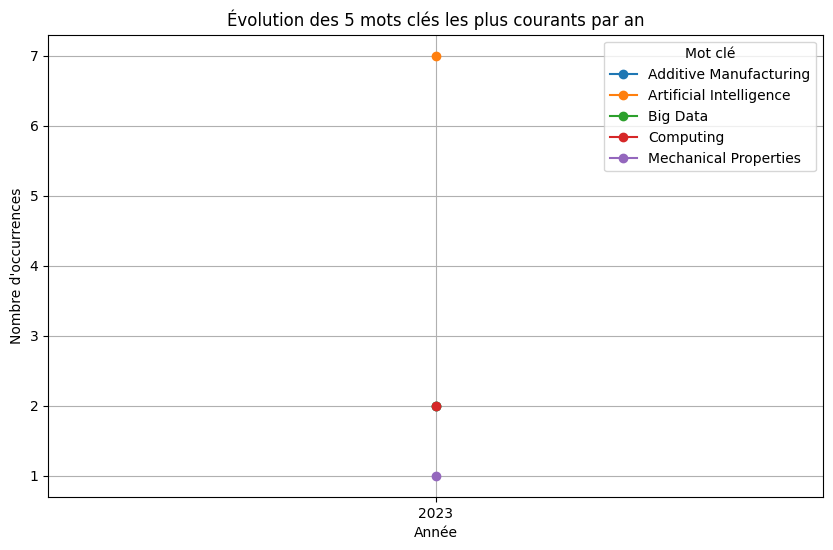

In [12]:
# 1. Conversion de la variable en DataFrame
rows = []
for binding in results["results"]["bindings"]:
    article = binding["article"]["value"]
    keyword = binding["keyword"]["value"]
    date_str = binding["date"]["value"]
    rows.append({'article': article, 'keyword': keyword, 'date': date_str})
df = pd.DataFrame(rows)

# 2. Conversion de la colonne date et extraction de l'année
df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year

# 3. Comptage des occurrences par mot clé et par année
grouped = df.groupby(["keyword", "year"]).size().reset_index(name="count")

# 4. Sélection des 5 mots clés les plus fréquents sur l'ensemble des données
top_keywords = df["keyword"].value_counts().head(5).index.tolist()

# Filtrage pour ne garder que les top 5 mots clés
grouped_top = grouped[grouped["keyword"].isin(top_keywords)]

# 5. Construction d'une table pivot (index = année, colonnes = mots clés, valeurs = compte)
pivot_df = grouped_top.pivot(index="year", columns="keyword", values="count").fillna(0)

# 6. Affichage des courbes en limitant l'axe des x aux années présentes
plt.figure(figsize=(10, 6))
for keyword in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[keyword], marker="o", label=keyword)
plt.xlabel("Année")
plt.ylabel("Nombre d'occurrences")
plt.title("Évolution des 5 mots clés les plus courants par an")
plt.legend(title="Mot clé")
plt.grid(True)
# Limiter les ticks de l'axe x aux années présentes dans pivot_df.index
plt.xticks(ticks=pivot_df.index, labels=pivot_df.index)
plt.show()